##### See "Cuneiform Identification Dimension Reduction and Model Exploration.ipynb", "Cuneiform Identification T-SVD Exploration.ipynb", and "Cuneiform Outlier Detection Exploration.ipynb" to see my process of selecting models, vectorizers, parameter grid combinations, and outlier detection decisions

### PLAN
- Use outlier detection
- Use min_df = 25

- Find my hyperparams with CountVectorization. However, train on both to compare

- Train two models

- Visualize the models

In [37]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer # tfidf weighting
from sklearn.feature_extraction.text import CountVectorizer #frequency distribution
import re
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.covariance import EllipticEnvelope # Mahalanobis Distance
import numpy as np
import matplotlib.pyplot as plt
import pickle
import plotly.express as px
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score,f1_score, make_scorer
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
'''nltk.download('stopwords')

nltk.download('wordnet')

nltk.download('punkt')'''

os.listdir()
cuneiform_whole = pd.read_csv("train.csv")
cuneiform_df = cuneiform_whole.sample(frac=0.25, random_state=251)
cuneiform_df.reset_index(drop=True, inplace = True)

### Preprocess the data

In [38]:
def preprocess_data(cuneiform_df, vectorizer):
    #split the data into training and testing sets
    X = cuneiform_df['cuneiform']
    y = cuneiform_df['lang']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=251)

    train_df = pd.DataFrame({'cuneiform': X_train, 'lang': y_train})
    test_df = pd.DataFrame({'cuneiform': X_test, 'lang': y_test})
    train_df.sort_values(by='lang', inplace=True)
    test_df.sort_values(by='lang', inplace=True)

    train_df.reset_index(drop=True, inplace = True)
    test_df.reset_index(drop=True, inplace = True)

    print("Data has been split!")

    #-----------------------Create a DTM---------------------------------------------

    #train the model
    tfidf_model = vectorizer.fit(train_df["cuneiform"])

    #apply it to the training data
    tfidf_matrix_train = vectorizer.transform(train_df["cuneiform"])

    #turn results into a document term matrix
    dense_matrix_train = tfidf_matrix_train.todense()   

    # Retrieve feature names (tokens)
    feature_names = vectorizer.get_feature_names_out() 

    # Create a DataFrame with the dense matrix and feature names as columns
    tfidf_df_train = pd.DataFrame(dense_matrix_train, columns=feature_names)

    #Create document term matrix of Test data
    tfidf_matrix_test = vectorizer.transform(test_df["cuneiform"])

    #turn results into a document term matrix
    dense_matrix_test = tfidf_matrix_test.todense()   

    # Retrieve feature names (tokens)
    feature_names = vectorizer.get_feature_names_out() 

    # Create a DataFrame with the dense matrix and feature names as columns
    tfidf_df_test = pd.DataFrame(dense_matrix_test, columns=feature_names)

    #----------------------- Preprocess and Standardize the Data ----------------------

    #Standardize data
    scaler = StandardScaler()
    scaler.fit(tfidf_df_train)
    training_df_standardized = pd.DataFrame(scaler.transform(tfidf_df_train), columns=tfidf_df_train.columns) #dataframe of standardized data
    test_df_standardized = pd.DataFrame(scaler.transform(tfidf_df_test), columns=tfidf_df_test.columns)

    #find local outliers with LOF
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
    # predict the labels for each data point (as Outlier or inlier)
    pred_lof = lof.fit_predict(training_df_standardized)

    #find outliers with isolation forrest
    iforest = IsolationForest(n_estimators=100,  contamination=0.01)
    # predict the labels for each data point (as Outlier or inlier)
    pred_if = iforest.fit_predict(training_df_standardized)

    #Add columns of the outlier results
    training_df_standardized["pred_lof"] = pred_lof
    training_df_standardized["pred_if"] = pred_if

    '''#find how many outliers there are
    lof_count = (training_df_standardized["pred_lof"] == -1).sum()
    if_count = (training_df_standardized["pred_if"] == -1).sum()
    total_count = ((training_df_standardized["pred_lof"] == -1) & (training_df_standardized["pred_if"] == -1)).sum()

    print("Outliers found by Local Outlier Factor :", lof_count)
    print("Outliers found by Isolation Forrest : ",if_count)
    print("Outliers Tagged by Both : ",total_count)

    percentage_outliers = (lof_count + if_count)/(training_df_standardized.shape[0])
    print(percentage_outliers * 100,'% of the training data are outliers')'''

    #remove the outliers
    outliers = training_df_standardized[(training_df_standardized["pred_lof"] == -1) | (training_df_standardized["pred_if"] == -1)][["pred_lof", "pred_if"]]
    #print("Outliers Found By Either Algorithm :")
    #display(outliers)

    #remove outliers from dataframe
    outlier_indices = outliers.index
    training_df_standardized.drop(outlier_indices, axis=0)
    train_df.drop(outlier_indices, axis= 0)


    x_subset_train = training_df_standardized.drop(['pred_lof', 'pred_if'], axis=1).values
    y_subset_train = train_df["lang"].values

    x_subset_test = test_df_standardized.values
    y_subset_test = test_df["lang"].values

    return [x_subset_train, x_subset_test, y_subset_train, y_subset_test]


tfidf_result = preprocess_data(cuneiform_whole, TfidfVectorizer(analyzer='char', min_df= 25))
count_result = preprocess_data(cuneiform_whole, CountVectorizer(analyzer='char', min_df=25))

Data has been split!
Data has been split!


### Finalize Hyperparam Tuning

In [39]:
def grad_boost(x_train, x_test, y_train, y_test, gb):

    gb.fit(x_train, y_train)

    gb_pred = gb.predict(x_test)
    label_names = ['LTB', 'MPB', 'NEA', 'NEB', 'OLB', 'STB', 'SUX']
    gb_report = classification_report(y_test, gb_pred, target_names = label_names)

    print(gb_report)

    unweighted_f1 = f1_score(y_test, gb_pred, average="macro")
    print("Average f1 score :", unweighted_f1)

    return [gb, gb_pred]

In [14]:
print("Performance of Count Vectorization, with best found previous hyperparameters : {'random_state': 251, 'max_iter': 300, 'max_depth': 200, 'loss': 'log_loss', 'learning_rate': 0.1}")
count_vec_grad_boost_historic = grad_boost(count_result[0], count_result[1], count_result[2], count_result[3], HistGradientBoostingClassifier(random_state=251, max_iter=300, max_depth=200, loss='log_loss', learning_rate=0.1))

Performance of Count Vectorization, with best found previous hyperparameters : {'random_state': 251, 'max_iter': 300, 'max_depth': 200, 'loss': 'log_loss', 'learning_rate': 0.1}
              precision    recall  f1-score   support

         LTB       0.88      0.91      0.89      3134
         MPB       0.83      0.72      0.77      1082
         NEA       0.79      0.83      0.81      6643
         NEB       0.82      0.52      0.64      1893
         OLB       0.89      0.70      0.78       738
         STB       0.75      0.66      0.70      3665
         SUX       0.89      0.97      0.92     10730

    accuracy                           0.84     27885
   macro avg       0.83      0.76      0.79     27885
weighted avg       0.84      0.84      0.84     27885

Average f1 score : 0.7896340817361333


In [20]:
print("Performance of Count Vectorization, with hyperparameters : {'random_state': 251, 'max_iter': 1200, 'max_depth': 300, 'loss': 'log_loss', 'learning_rate': 0.05}")
count_vec_grad_boost_tuned = grad_boost(count_result[0], count_result[1], count_result[2], count_result[3], HistGradientBoostingClassifier(random_state=251, max_iter=1200, max_depth=300, loss='log_loss', learning_rate=0.05))

Performance of Count Vectorization, with hyperparameters : {'random_state': 251, 'max_iter': 1200, 'max_depth': 300, 'loss': 'log_loss', 'learning_rate': 0.05}
              precision    recall  f1-score   support

         LTB       0.90      0.92      0.91      3134
         MPB       0.85      0.75      0.80      1082
         NEA       0.80      0.84      0.82      6643
         NEB       0.83      0.55      0.66      1893
         OLB       0.91      0.72      0.80       738
         STB       0.76      0.69      0.72      3665
         SUX       0.89      0.97      0.93     10730

    accuracy                           0.85     27885
   macro avg       0.85      0.78      0.81     27885
weighted avg       0.85      0.85      0.85     27885

Average f1 score : 0.8070378641165845


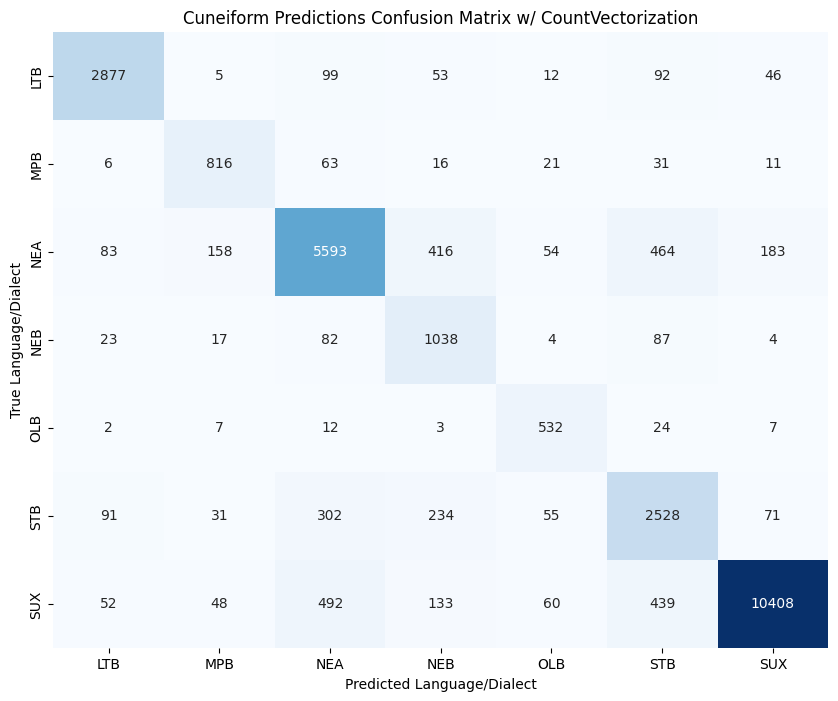

In [21]:
#Create and display the confusion matrix
conf_matrix_count = confusion_matrix(count_vec_grad_boost_tuned[1], count_result[3])

label_names = ['LTB', 'MPB', 'NEA', 'NEB', 'OLB', 'STB', 'SUX']

# Convert the confusion matrix to a DataFrame for better visualization
conf_df_count = pd.DataFrame(conf_matrix_count, index=label_names, columns=label_names)

# Plotting with Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df_count, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Cuneiform Predictions Confusion Matrix w/ CountVectorization')
plt.xlabel('Predicted Language/Dialect')
plt.ylabel('True Language/Dialect')

plt.show()

In [40]:
tfidf_result = preprocess_data(cuneiform_whole, TfidfVectorizer(analyzer='char', min_df= 25))

Data has been split!


In [23]:
print("Performance of TFIDF Vectorization, with best found previous hyperparameters : {'random_state': 251, 'max_iter': 200, 'max_depth': 200, 'loss': 'log_loss', 'learning_rate': 0.1}")
tfidf_vec_grad_boost_historic = grad_boost(tfidf_result[0], tfidf_result[1], tfidf_result[2], tfidf_result[3], HistGradientBoostingClassifier(random_state=251, max_iter=200, max_depth=400, loss='log_loss', learning_rate=0.1))

Performance of TFIDF Vectorization, with best found previous hyperparameters : {'random_state': 251, 'max_iter': 200, 'max_depth': 200, 'loss': 'log_loss', 'learning_rate': 0.1}
              precision    recall  f1-score   support

         LTB       0.89      0.90      0.89      3134
         MPB       0.81      0.71      0.75      1082
         NEA       0.78      0.83      0.80      6643
         NEB       0.80      0.51      0.62      1893
         OLB       0.86      0.68      0.76       738
         STB       0.73      0.63      0.68      3665
         SUX       0.88      0.97      0.92     10730

    accuracy                           0.83     27885
   macro avg       0.82      0.75      0.78     27885
weighted avg       0.83      0.83      0.83     27885

Average f1 score : 0.7760988683515289


In [41]:
print("Performance of TFIDF Vectorization, with best found previous hyperparameters : {'random_state': 251, 'max_iter': 1200, 'max_depth': 300, 'loss': 'log_loss', 'learning_rate': 0.05}")
tfidf_vec_grad_boost_tuned = grad_boost(tfidf_result[0], tfidf_result[1], tfidf_result[2], tfidf_result[3], HistGradientBoostingClassifier(random_state=251, max_iter=1200, max_depth=300, loss='log_loss', learning_rate=0.05))

Performance of TFIDF Vectorization, with best found previous hyperparameters : {'random_state': 251, 'max_iter': 1200, 'max_depth': 300, 'loss': 'log_loss', 'learning_rate': 0.05}
              precision    recall  f1-score   support

         LTB       0.90      0.91      0.91      3134
         MPB       0.82      0.74      0.78      1082
         NEA       0.80      0.84      0.82      6643
         NEB       0.81      0.54      0.65      1893
         OLB       0.88      0.71      0.79       738
         STB       0.75      0.67      0.71      3665
         SUX       0.90      0.97      0.93     10730

    accuracy                           0.85     27885
   macro avg       0.84      0.77      0.80     27885
weighted avg       0.85      0.85      0.84     27885

Average f1 score : 0.797304077647461


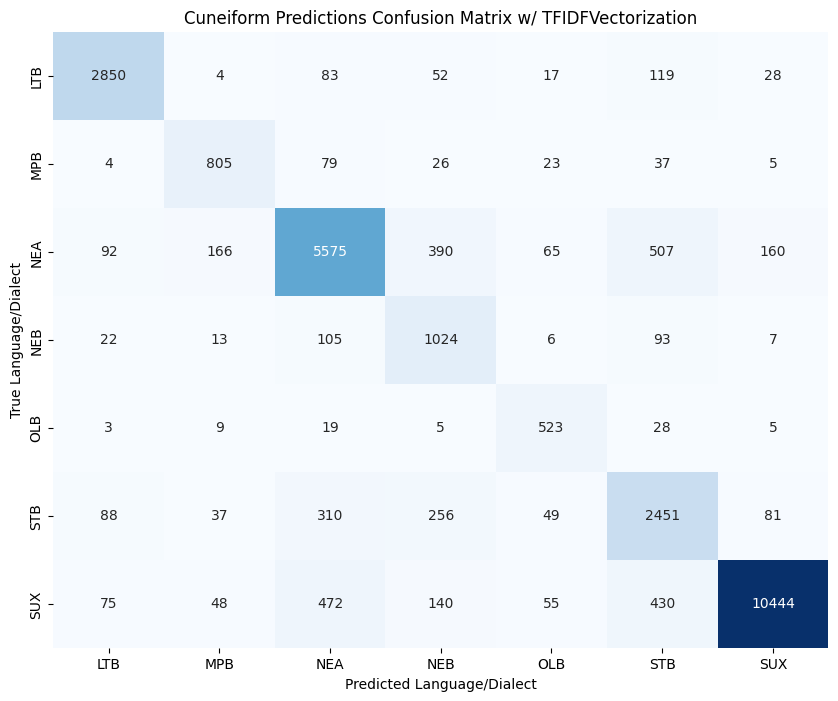

In [42]:
#Create and display the confusion matrix
conf_matrix_tfidf = confusion_matrix(tfidf_vec_grad_boost_tuned[1], tfidf_result[3])

label_names = ['LTB', 'MPB', 'NEA', 'NEB', 'OLB', 'STB', 'SUX']

# Convert the confusion matrix to a DataFrame for better visualization
conf_df_tfidf = pd.DataFrame(conf_matrix_tfidf, index=label_names, columns=label_names)

# Plotting with Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df_tfidf, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Cuneiform Predictions Confusion Matrix w/ TFIDFVectorization')
plt.xlabel('Predicted Language/Dialect')
plt.ylabel('True Language/Dialect')

plt.show()

##### While I did not focus on Akkadian vs Summerian Identification in my hyperparameter tuning, I'll quickly train a model to do so.

In [19]:
cuneiform_df['language_group'] = cuneiform_df['lang'].apply(lambda x: 'SUX' if x == 'SUX' else 'AKK')
cuneiform_whole['language_group'] = cuneiform_whole['lang'].apply(lambda x: 'SUX' if x == 'SUX' else 'AKK')


In [4]:

def preprocess_data_languages(cuneiform_df, vectorizer):
    #split the data into training and testing sets
    X = cuneiform_df['cuneiform']
    y = cuneiform_df['language_group']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=251)

    train_df = pd.DataFrame({'cuneiform': X_train, 'language_group': y_train})
    test_df = pd.DataFrame({'cuneiform': X_test, 'language_group': y_test})
    train_df.sort_values(by='language_group', inplace=True)
    test_df.sort_values(by='language_group', inplace=True)

    train_df.reset_index(drop=True, inplace = True)
    test_df.reset_index(drop=True, inplace = True)

    print("Data has been split!")

    #-----------------------Create a DTM---------------------------------------------

    #train the model
    tfidf_model = vectorizer.fit(train_df["cuneiform"])

    #apply it to the training data
    tfidf_matrix_train = vectorizer.transform(train_df["cuneiform"])

    #turn results into a document term matrix
    dense_matrix_train = tfidf_matrix_train.todense()   

    # Retrieve feature names (tokens)
    feature_names = vectorizer.get_feature_names_out() 

    # Create a DataFrame with the dense matrix and feature names as columns
    tfidf_df_train = pd.DataFrame(dense_matrix_train, columns=feature_names)

    #Create document term matrix of Test data
    tfidf_matrix_test = vectorizer.transform(test_df["cuneiform"])

    #turn results into a document term matrix
    dense_matrix_test = tfidf_matrix_test.todense()   

    # Retrieve feature names (tokens)
    feature_names = vectorizer.get_feature_names_out() 

    # Create a DataFrame with the dense matrix and feature names as columns
    tfidf_df_test = pd.DataFrame(dense_matrix_test, columns=feature_names)

    #----------------------- Preprocess and Standardize the Data ----------------------

    #Standardize data
    scaler = StandardScaler()
    scaler.fit(tfidf_df_train)
    training_df_standardized = pd.DataFrame(scaler.transform(tfidf_df_train), columns=tfidf_df_train.columns) #dataframe of standardized data
    test_df_standardized = pd.DataFrame(scaler.transform(tfidf_df_test), columns=tfidf_df_test.columns)

    #find local outliers with LOF
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
    # predict the labels for each data point (as Outlier or inlier)
    pred_lof = lof.fit_predict(training_df_standardized)

    #find outliers with isolation forrest
    iforest = IsolationForest(n_estimators=100,  contamination=0.01)
    # predict the labels for each data point (as Outlier or inlier)
    pred_if = iforest.fit_predict(training_df_standardized)

    #Add columns of the outlier results
    training_df_standardized["pred_lof"] = pred_lof
    training_df_standardized["pred_if"] = pred_if

    '''#find how many outliers there are
    lof_count = (training_df_standardized["pred_lof"] == -1).sum()
    if_count = (training_df_standardized["pred_if"] == -1).sum()
    total_count = ((training_df_standardized["pred_lof"] == -1) & (training_df_standardized["pred_if"] == -1)).sum()

    print("Outliers found by Local Outlier Factor :", lof_count)
    print("Outliers found by Isolation Forrest : ",if_count)
    print("Outliers Tagged by Both : ",total_count)

    percentage_outliers = (lof_count + if_count)/(training_df_standardized.shape[0])
    print(percentage_outliers * 100,'% of the training data are outliers')'''

    #remove the outliers
    outliers = training_df_standardized[(training_df_standardized["pred_lof"] == -1) | (training_df_standardized["pred_if"] == -1)][["pred_lof", "pred_if"]]
    #print("Outliers Found By Either Algorithm :")
    #display(outliers)

    #remove outliers from dataframe
    outlier_indices = outliers.index
    training_df_standardized.drop(outlier_indices, axis=0)
    train_df.drop(outlier_indices, axis= 0)


    x_subset_train = training_df_standardized.drop(['pred_lof', 'pred_if', 'lang'], axis=1).values
    y_subset_train = train_df["language_group"].values

    x_subset_test = test_df_standardized.values
    y_subset_test = test_df["language_group"].values

    return [x_subset_train, x_subset_test, y_subset_train, y_subset_test]

In [20]:
tfidf_result_sample_lang = preprocess_data_languages(cuneiform_df, TfidfVectorizer(analyzer='char', min_df= 25))
tfidf_result_lang = preprocess_data_languages(cuneiform_whole, TfidfVectorizer(analyzer='char', min_df= 25))

Data has been split!
Data has been split!


In [6]:
def grid_search_func(x_subset, y_subset, model, param_grid, iterations):
    #grid = RandomizedSearchCV(model, param_grid, random_state=251, scoring='f1_samples' ,n_iter=iterations, n_jobs=-1, return_train_score=True)

    grid = RandomizedSearchCV(model, param_grid, random_state=251, scoring = 'f1_macro', n_iter=iterations, n_jobs=-1, return_train_score=True)

    #fit the model
    grid.fit(x_subset, y_subset)

    #best parameters
    best_params = grid.best_params_

    #df of parameters and their r2 scores
    param_results = pd.DataFrame(grid.cv_results_)
    
    return [best_params, param_results]

In [9]:
gradient_boost_grid = {
    'random_state' : [251],
    'loss' : ['log_loss'],
    'learning_rate' : [0.05, 0.1,],
    'max_iter' : [200, 500, 1200],
    'max_depth' : [100, 200, 300],
}

In [11]:
#do a grid search
gb_result_count = grid_search_func(tfidf_result_sample_lang[0], tfidf_result_sample_lang[2], HistGradientBoostingClassifier(), gradient_boost_grid, 10)
gb_param_count_df = gb_result_count[1][['params','mean_test_score', 'rank_test_score']].sort_values(by = 'rank_test_score', kind = 'mergesort')

print("Grid Results of Gradient Boost Model, For Akkadian vs Sumerian identification")
display(gb_param_count_df)
print("Best Parameters :", gb_result_count[0])

Grid Results of Gradient Boost Model, For Akkadian vs Sumerian identification


,params,mean_test_score,rank_test_score
0,"{'random_state': 251, 'max_iter': 500, 'max_de...",0.924071,1
1,"{'random_state': 251, 'max_iter': 1200, 'max_d...",0.924071,1
7,"{'random_state': 251, 'max_iter': 500, 'max_de...",0.924071,1
3,"{'random_state': 251, 'max_iter': 1200, 'max_d...",0.923829,4
6,"{'random_state': 251, 'max_iter': 1200, 'max_d...",0.923829,4
8,"{'random_state': 251, 'max_iter': 500, 'max_de...",0.923829,4
2,"{'random_state': 251, 'max_iter': 200, 'max_de...",0.922827,7
9,"{'random_state': 251, 'max_iter': 200, 'max_de...",0.922827,7
4,"{'random_state': 251, 'max_iter': 200, 'max_de...",0.919016,9
5,"{'random_state': 251, 'max_iter': 200, 'max_de...",0.919016,9


Best Parameters : {'random_state': 251, 'max_iter': 500, 'max_depth': 100, 'loss': 'log_loss', 'learning_rate': 0.1}


In [23]:
def grad_boost_sum_vs_akk(x_train, x_test, y_train, y_test, gb):


    gb.fit(x_train, y_train)

    gb_pred = gb.predict(x_test)
    label_names = ['AKK', 'SUX']
    gb_report = classification_report(y_test, gb_pred, target_names = label_names)

    print(gb_report)

    unweighted_f1 = f1_score(y_test, gb_pred, average="macro")
    print("Average f1 score :", unweighted_f1)

    return [gb, gb_pred]

In [24]:
print("Performance of Akkadian vs Sumerian language Identification , with best found previous hyperparameters : {'random_state': 251, 'max_iter': 500, 'max_depth': 100, 'loss': 'log_loss', 'learning_rate': 0.1}")
grad_boost_sum_vs_akk = grad_boost_sum_vs_akk(tfidf_result_lang[0], tfidf_result_lang[1], tfidf_result_lang[2], tfidf_result_lang[3], HistGradientBoostingClassifier(random_state=251, max_iter=500, max_depth=100, loss='log_loss', learning_rate=0.1))

Performance of Akkadian vs Sumerian language Identification , with best found previous hyperparameters : {'random_state': 251, 'max_iter': 500, 'max_depth': 100, 'loss': 'log_loss', 'learning_rate': 0.1}
              precision    recall  f1-score   support

         AKK       0.97      0.94      0.95     17155
         SUX       0.91      0.95      0.93     10730

    accuracy                           0.94     27885
   macro avg       0.94      0.94      0.94     27885
weighted avg       0.94      0.94      0.94     27885

Average f1 score : 0.9407795342957026


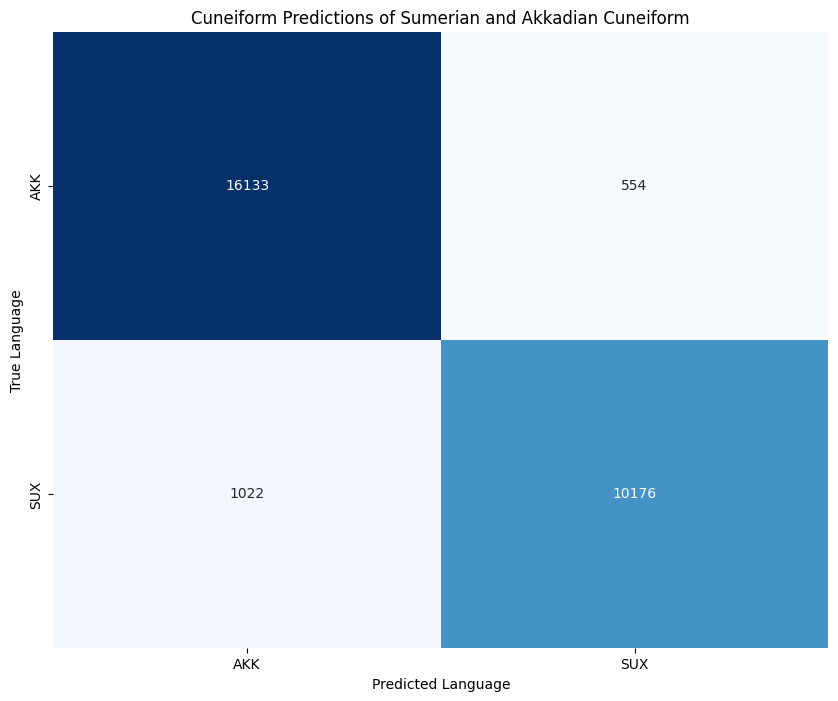

In [36]:
#Create and display the confusion matrix
conf_matrix_sum_vs_akk = confusion_matrix(grad_boost_sum_vs_akk[1], tfidf_result_lang[3])

label_names = ['AKK', 'SUX']

# Convert the confusion matrix to a DataFrame for better visualization
conf_df_sum_vs_akk = pd.DataFrame(conf_matrix_sum_vs_akk, index=label_names, columns=label_names)

# Plotting with Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df_sum_vs_akk, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Cuneiform Predictions of Sumerian and Akkadian Cuneiform')
plt.xlabel('Predicted Language')
plt.ylabel('True Language')

plt.show()